In [19]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import nltk
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer


Connect the dataset from sqlite file

In [20]:
con = sqlite3.connect("database.sqlite")

Display some row to see how the dataset looks like

In [21]:
display = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


For this case, there is attribute of score can be used as label. Hence, We are going to filter data with the score of 3, as the neutral comment cannot be categorised into either positive comment or negative comment. Furthermore, the data with the score that is greater than 3 is going to be considered as positive comment, whereas the data with the score that smaller than 3 is going to be considered as negative comment.

In [22]:
filtered_data = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE != 3""",con)

In [23]:
def partistion(x):
    if x < 3:
        return "negative"
    return "positive"

Then, all the score in the dataset are changed and replace with value of "positive" or "negative"

In [24]:
ActualScore = filtered_data['Score']
PositiveNegative = ActualScore.map(partistion)
filtered_data['Score'] = PositiveNegative

filtered_data.shape
filtered_data


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,positive,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,negative,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,positive,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,positive,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


Now, let's us have a look into some data. There are some duplicated or same review keep on commented by one userid. In this scenario, the user with the userID (AR5J8UI46CURR) has commented 5 reviews with the same content on the the same product with different flavors. 
The productID "B000HDL1RQ" is the "Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8)"
The productID "B000HDOPZG" is the "Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)"

Hence, We need to remove the the rows having same parameters in oreder to reduce the redundancy  

In [25]:
display = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE != 3 AND UserId ="AR5J8UI46CURR" ORDER BY ProductId""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


The method that we used is sorted the data by ProductID, then use the "drop_duplicates" method to remove the duplicated content. In this case, when the "UserId", "ProfileName", "Time" and "Text" are the same in a subset, then the only first row will be kept and the rest of the row will be removed. 

In [75]:
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False, kind='quicksort', na_position='last')

In [27]:
final = sorted_data.drop_duplicates(subset=('UserId','ProfileName','Time','Text'),keep='first',inplace=False)
final.shape

(364173, 10)

Checking the data left after remove the redundancy. Is around 70% left after remove the redundancy.

In [28]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

One more thing that we should careful with is the attribute of HelpfulnessNumerator and HelpfulnessDenominator. From the defination, we know that the HelpfulnessNumerator is the number of users who found the review helpful, while HelpfulnessDenominator is the number of users who indicated whether they found the review helpful or not.

Therefore, we need to check a condition for the data, is it the "HelpfulnessNumerator > HelpfulnessDenominator" has occurred in the data set. If so, we need to remove the particular row. This is because when the value of HelpfulnessNumerator is graeter than the value of HelpfulnessDenominator, then the particular row will make no sense.

In [76]:
display = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE != 3 AND HelpfulnessNumerator > HelpfulnessDenominator ORDER BY ProductID""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [30]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

print(final.shape)

(364171, 10)


After we remove the data with "HelpfulnessNumerator > HelpfulnessDenominator", then we have a count on how many row consider as positive review and how many row consider as negative review. In our case, there are 307062 row consider as positive review; whereas 57110 row consider as negative review

In [31]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

One more important thing, this is the review from a web application, so, we need to check with "Is the text inside the review has contain the HTML tag?". One example has been showned as below. In this example, it is contained of "<br />" as the HTML tag.

In [32]:
i = 0;
for sent in final['Text'].values:
    if (re.findall('<.*?>',sent)):
        print(i)
        print(sent)
        break;
    i +=1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Hence, we need to remove the HTML tag for our data. Therefore, a cleanhtml() funtion have been created in order to remove the HTML tag.Furthermore, we also need to eliminate the punctuation from text. Hence, cleanpunc function have been created. Moreover, in order to tokenise the words in text or count the words in the text, we need to stem the word in order to produce a root/base word for the text. After this process, we store all words from the positive review into "all_positive_words", while storing all the words from negative review into "all_negative_words"

In [34]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemming

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

{"you're", "that'll", 'should', "it's", 'doesn', 'on', 'where', 'nor', 'ours', "hasn't", 'more', 'for', 'below', 'ain', 'most', "shan't", 'no', 'this', 'your', 'been', 'as', 'aren', 'i', 'him', "haven't", 'yourself', 'because', 'all', 'wouldn', 'of', 'against', 'our', 'is', 'they', 'under', 'there', 'when', 'just', "you'll", 'than', "should've", 'those', 'then', 'm', 'be', 'd', "wouldn't", 'few', 'will', 'ma', 've', 'over', 'to', 'can', 'o', 'into', 'don', 'here', 'after', 'what', 'doing', 'mightn', 'in', 'if', 'with', 'now', 'were', 'own', 'once', 'each', "wasn't", 'isn', 'very', 'shouldn', 'the', 'hadn', 'out', 'does', 'them', 'are', 'having', 'he', 'theirs', 're', 'any', "aren't", 'wasn', 'about', 'll', 'that', "hadn't", 'hers', 'did', 'by', 'weren', 'being', 'it', 'itself', 'yourselves', "mustn't", "won't", 'ourselves', 'am', 'further', 'and', "shouldn't", 'you', 'up', 'their', 'we', "needn't", 'or', "you've", 'herself', 't', 'didn', 'me', 'himself', 'too', "doesn't", "mightn't", '

In [37]:
#code for implementing step-by-step the checks mentioned in the pre-process
i = 0
str1 = ' '
final_string = []
all_positive_words = [] #store words from +ve reviews here
all_negative_words = [] #store words from -ve reviews here
s = ''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent = cleanhtml(sent) #remove HTML tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i]=='positive':
                        all_positive_words.append(s) #list of all words that are positve
                    if (final['Score'].values)[i]=='negative':
                        all_negative_words.append(s) #list of all words that are negative
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i +=1

After done the processing data, we stored the final data into "final.sqlite" for further usage.

In [38]:
final['CleanedText']=final_string #adding a column of cleanedtext to final

In [39]:
final.head(3)

#store final table into an SQL Lite table for future

conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
final.to_sql('Reviews',conn,schema=None,if_exists='replace')

After cleaned and processed the text, we apply the Bog of Words method to it. Hence, we start to count the word for "all_positive_words" and "all_negative_words" by single word.

In [83]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['CleanedText'].values)

In [84]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [85]:
final_counts.shape

(364171, 71624)

In [80]:
len(all_positive_words)

11610503

There are two lists that are showing the Top 20 of the "Most Common Positive words" and "Most Common Negative words" at the below respectively.
Furthermore, there are two graphs are showing the Top 30 of most frequently used words in "Most Common Positive words" and "Most Common Negative words" at the below respectively.

In [81]:
freq_dist_positive = nltk.FreqDist(all_positive_words)
freq_dist_negative = nltk.FreqDist(all_negative_words)
print("Most Common Positive words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


Graph of the Top 30 from "Most Common Positive words"

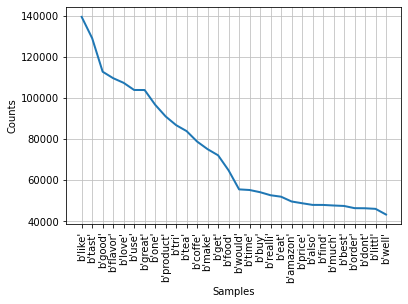

In [82]:
import matplotlib.pyplot as plt
freq_dist_positive.plot(30,cumulative=False)
plt.show()

Graph of the Top 30 from "Most Common Negative words"

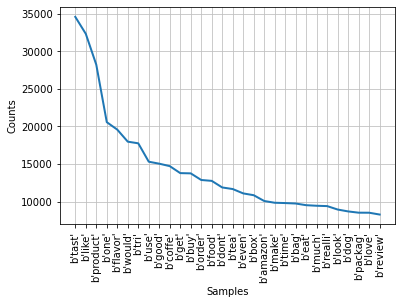

In [89]:
import matplotlib.pyplot as plt
freq_dist_negative.plot(30,cumulative=False)
plt.show()

From the result at the above, we can observe that the most common positive and the negative words are overlaped. In our case, the most common positive words and most common negative words share the same words, such as "like" and "taste". However, the accuracy of the model is calculated by the following steps. The accuarcy of the model is 90.27%.

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    final_counts, final['Score'], test_size=0.2, random_state=1)

In [47]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.9026704194412027


From the result above, since the most positive words and most negative words overlap, then maybe we can try on set two words as one words for the modeling. For example, this can distinguish the "like" and "not like".

In [90]:
#bi_gram
count_vect = CountVectorizer(ngram_range=(1,2))
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)

(364171, 2910192), 

In [91]:
final_bigram_counts.shape

(364171, 2923725)

In [98]:
features = count_vect.get_feature_names()
features[100000:100010]

['antler fair',
 'antler fall',
 'antler fantast',
 'antler far',
 'antler fault',
 'antler favorit',
 'antler feel',
 'antler french',
 'antler get',
 'antler girl']

In [103]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    final_bigram_counts, final['Score'], test_size=0.2, random_state=1)

In [104]:
from sklearn.naive_bayes import MultinomialNB
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
#Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.9059380792201551


The accuracy of the bi-gram model is calculated. The accuarcy of the model is 90.59%. Slightly increase from the first model.

Now, We try to use the TF-IDF (Term frequency–Inverse document frequency) to improve the model of the data.

In [111]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)

(364171, 2910192)

In [55]:
features = tf_idf_vect.get_feature_names()

In [56]:
features[100000:100010]

['antler fair',
 'antler fall',
 'antler fantast',
 'antler far',
 'antler fault',
 'antler favorit',
 'antler feel',
 'antler french',
 'antler get',
 'antler girl']

In [54]:
final_tf_idf.shape

(364171, 2923725)

In [105]:
print(final_tf_idf)

  (0, 1588504)	0.14746031123802034
  (0, 2079056)	0.1521656780979496
  (0, 1740)	0.1521656780979496
  (0, 2442797)	0.10474848449221195
  (0, 2370520)	0.12433843297974188
  (0, 231584)	0.1521656780979496
  (0, 2853606)	0.12285494427043678
  (0, 277878)	0.1521656780979496
  (0, 480955)	0.1521656780979496
  (0, 2299365)	0.1521656780979496
  (0, 1323650)	0.1521656780979496
  (0, 277460)	0.1441218003209496
  (0, 2872057)	0.14746031123802034
  (0, 1700739)	0.1360779225439496
  (0, 1508080)	0.09751222730291975
  (0, 776796)	0.1521656780979496
  (0, 1291249)	0.1521656780979496
  (0, 2837196)	0.1521656780979496
  (0, 1424471)	0.1521656780979496
  (0, 1214801)	0.13762753600525887
  (0, 2090711)	0.1521656780979496
  (0, 2308823)	0.1521656780979496
  (0, 78123)	0.1521656780979496
  (0, 63379)	0.1441218003209496
  (0, 775476)	0.13762753600525887
  :	:
  (364170, 920462)	0.10498099379984843
  (364170, 1180567)	0.13710644389249513
  (364170, 1507979)	0.09850378622516898
  (364170, 919456)	0.070873259

In [112]:
print("n_samples: %d, n_features: %d" % final_tf_idf.shape)

n_samples: 364171, n_features: 2923725


In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    final_tf_idf, final['Score'], test_size=0.2, random_state=123)

In [114]:
print("n_samples: %d, n_features: %d" % X_train.shape)

n_samples: 291336, n_features: 2923725


So, we can see that, there are 291336 data points and 2923725 features.

In [115]:
print("n_samples: %d, n_features: %d" % X_test.shape)

n_samples: 72835, n_features: 2923725


So, we can see that the number of features is the same. Now we can proceed with creating the classifier.

Naive Bayes Classifier

In [177]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)
predicted= clf.predict(X_test)


Check with the classification report. The accuracy is 91%.

In [178]:
print(metrics.classification_report(y_test, predicted, target_names=['Positive', 'Negative']))

              precision    recall  f1-score   support

    Positive       0.83      0.50      0.63     11372
    Negative       0.91      0.98      0.95     61463

    accuracy                           0.91     72835
   macro avg       0.87      0.74      0.79     72835
weighted avg       0.90      0.91      0.90     72835



Check with the confusion matrix

In [119]:
print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, predicted))

Confusion matrix:
[[ 5727  5645]
 [ 1206 60257]]


Doing a Test Prediction on Reviews Classifier Using TF-IDF

In [170]:
#doing a test prediction
test = [" I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most."]

In [163]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [171]:
import string
from nltk.stem import WordNetLemmatizer
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [172]:
review = re.sub('[^a-zA-Z]', ' ', test[0])
review = review.lower()
review = review.split()
review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords)]
test_processed =[ ' '.join(review)]

In [173]:
test_processed

['bought several vitality canned dog food product found good quality product look like stew processed meat smell better labrador finicky appreciates product better']

In [174]:
test_input = tf_idf_vect.transform(test_processed)
test_input.shape

(1, 2923725)

It also has 2923725 features.

In [179]:
#0= bad review
#1= good review
res=clf.predict(test_input)[0]

if res=="negative":
    print("Negative Review")
elif res=="positive":
    print("Positive Review")

Positive Review


The classifier is able to classify the test data as positive review.